In [1]:
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

# multiprocessing
import torch.multiprocessing as mp
from functools import partial

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
import torch_directml

# custom
from scripts.classes import Botzee
from scripts.functions import play_botzee, model_pick_dice, model_pick_score, reinforce_by_turn

In [2]:
with open('models/botzee_base_args.pkl', 'rb') as f:
    botzee_base_args = pickle.load(f)

botzee = Botzee(
    input_sizes = botzee_base_args['input_sizes'],
    lstm_sizes = botzee_base_args['lstm_sizes'], 
    dice_output_size = botzee_base_args['dice_output_size'], 
    score_output_size = botzee_base_args['score_output_size'], 
    masks = botzee_base_args['masks']
)

# botzee = torch.load('models/botzee_base.pth')

Baseline: 45.01


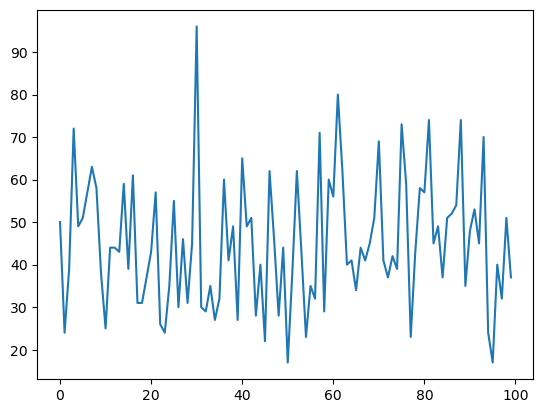

In [3]:
n_baseline_games = 10**2

final_scores = []

for i in range(n_baseline_games):
    game_data = play_botzee(
        game_number = 0, dice_function = model_pick_dice, score_function = model_pick_score, 
        model = botzee, rl = False
    )

    final_score = game_data[-1]['post_total_score']

    final_scores.append(final_score)

baseline = np.mean(final_scores)

print(f'Baseline: {baseline}')

fig, ax = plt.subplots()
ax.plot(final_scores)
plt.show()

In [4]:
n_episodes = 10 # **4
n_games = 10

optimizer = torch.optim.SGD(botzee.parameters(), lr = 0.01)

botzee.train()

Botzee(
  (lstm1): LSTM(34, 34)
  (fc1): Linear(in_features=34, out_features=34, bias=True)
  (branch1): Linear(in_features=34, out_features=5, bias=True)
  (lstm2): LSTM(57, 57)
  (fc2): Linear(in_features=57, out_features=57, bias=True)
  (branch2): Linear(in_features=57, out_features=5, bias=True)
  (lstm3): LSTM(80, 80)
  (fc3): Linear(in_features=80, out_features=80, bias=True)
  (branch3): Linear(in_features=80, out_features=13, bias=True)
)

In [5]:
start = time.perf_counter()

total_scores = []
losses = []

for episode in range(1, n_episodes + 1):

    # Play game
    game_data, dice_probs_1, dice_probs_2, score_pick_probs = play_botzee(
        game_number = 0, 
        dice_function = model_pick_dice, 
        score_function = model_pick_score, 
        model = botzee,
        rl = True
    )
    total_score = game_data[-1]['post_total_score']
    rewards = [x['turn_score'] for x in game_data]
    advantages = [reward - baseline for reward in rewards]

    # Initialize lists for concatenated log probabilities
    concatenated_log_probs = []

    # Iterate through each turn and concat log probs
    for dp1, dp2, sp in zip(dice_probs_1, dice_probs_2, score_pick_probs):
        turn_log_probs = torch.cat([dp1, dp2, sp.unsqueeze(0)])
        concatenated_log_probs.append(turn_log_probs)

    # # Apply discounting to rewards
    # discount_factor = 0.999
    # discounted_rewards = []
    # R = 0
    # for r in reversed(rewards):
    #     R = r + discount_factor * R
    #     discounted_rewards.insert(0, R)

    # # Normalize the advanatges / rewards
    # mean_rewards = torch.mean(torch.tensor(rewards, dtype = torch.float64))
    # std_rewards = torch.std(torch.tensor(rewards, dtype = torch.float64))
    # normalized_rewards = [(reward - mean_rewards) / (std_rewards + 1e-9) for reward in rewards]

    # Calculate policy gradient loss
    loss = []
    for log_probs, advantage in zip(concatenated_log_probs, advantages):
        for log_prob in log_probs:
            loss.append(-log_prob * advantage)  # Negative because we're doing gradient ascent
    loss = torch.sum(torch.stack(loss))

    # Update the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_scores.append(total_score)
    losses.append(loss)

    if episode % (n_episodes / 10) == 0:
        end = time.perf_counter()
        print(
            f'Episode [{episode}], Mean Adv.: {np.mean(advantages):.4f}, Loss: {loss:.4f}\n'
            f'Time elapsed - {(end - start) / 60:.2f} min'
        )

Episode [1], Mean Adv.: -38.0100, Loss: -4234.0605
Time elapsed - 0.00 min
Episode [2], Mean Adv.: -41.9331, Loss: -3833.7861
Time elapsed - 0.00 min
Episode [3], Mean Adv.: -43.0869, Loss: -3772.8469
Time elapsed - 0.00 min
Episode [4], Mean Adv.: -41.3177, Loss: -2158.1628
Time elapsed - 0.00 min
Episode [5], Mean Adv.: -42.7023, Loss: -3572.8542
Time elapsed - 0.01 min
Episode [6], Mean Adv.: -39.0869, Loss: -2394.2778
Time elapsed - 0.01 min
Episode [7], Mean Adv.: -42.7023, Loss: -2933.2188
Time elapsed - 0.01 min
Episode [8], Mean Adv.: -43.0100, Loss: -3447.6914
Time elapsed - 0.01 min
Episode [9], Mean Adv.: -42.8562, Loss: -2810.7119
Time elapsed - 0.01 min
Episode [10], Mean Adv.: -42.2408, Loss: -1555.6631
Time elapsed - 0.01 min


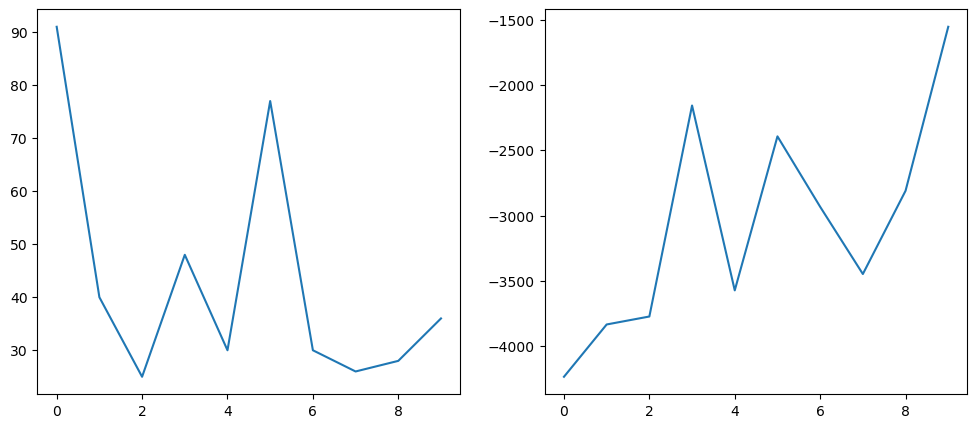

In [6]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

axes[0].plot(total_scores)
axes[1].plot([x.item() for x in losses])

plt.show()

In [7]:
# i = 0
# for param in botzee.parameters():
#     print(param.data)
#     i += 1
#     if i >= 5:
#         break

# for name, param in botzee.named_parameters():
#     if param.grad is not None:
#         print(f"Gradient of {name}: {param.grad.data}")
#     else:
#         print(f"No gradient for {name}")

In [8]:
if __name__ == "__main__":
    mp.set_start_method('spawn', force=True)

    total_episodes = 10**5
    num_processes = 10

    botzee = Botzee(
        input_sizes = botzee_base_args['input_sizes'],
        lstm_sizes = botzee_base_args['lstm_sizes'], 
        dice_output_size = botzee_base_args['dice_output_size'], 
        score_output_size = botzee_base_args['score_output_size'], 
        masks = botzee_base_args['masks']
    )
    botzee.share_memory()
    optimizer = torch.optim.SGD(botzee.parameters(), lr = 0.01)
    baseline = 100

    worker = partial(reinforce_by_turn, model = botzee, optimizer = optimizer, baseline = baseline)

    with mp.Pool(processes = num_processes) as pool:
        results = pool.map(worker, [x for x in range(total_episodes)])

In [9]:
scores = [result[0] for result in results]
losses = [result[1] for result in results]
advantages = [result[2] for result in results]

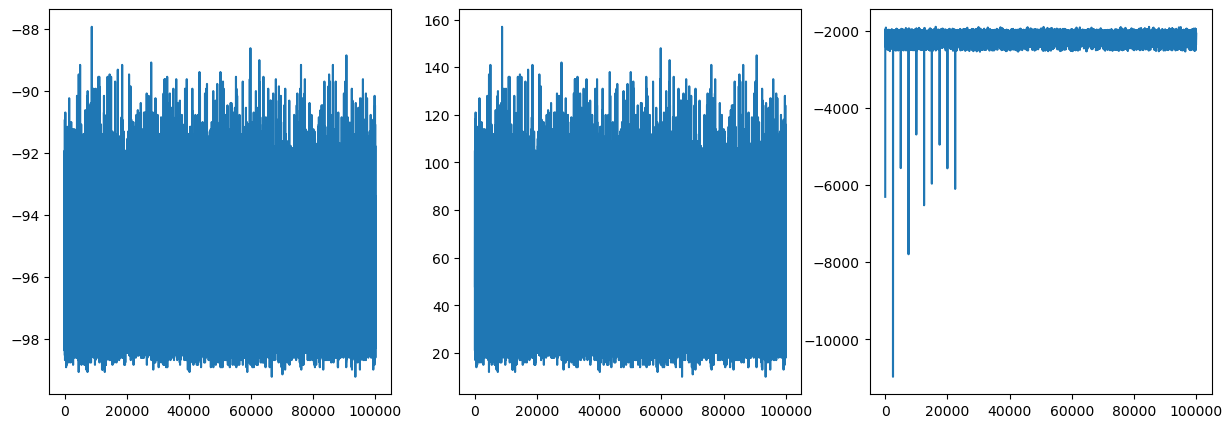

In [10]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

axes[0].plot([np.mean(x) for x in advantages])
axes[1].plot(scores)
axes[2].plot(losses)

plt.show()